In [185]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

import sklearn.preprocessing as prep
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess

name = '/home/mabbasloo/Documents/carData4/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [186]:
filename = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/list'
st = 10
stride = 6
with open(filename) as f:
    data = f.readlines() 
data = [x.strip() for x in data]   
data = sorted(data, key=lambda x:x[0:4])[0::stride]
print (len(data), np.int(len(data)/st))
for i in range(5*st):
    print (data[i])
#print (data[len(data)-1])
#for i in range(len(data)):
#    print (data[i])

2050 205
f001_S2000001_1.mat
f001_S2000001_7.mat
f001_S2000001_13.mat
f001_S2000001_19.mat
f001_S2000001_25.mat
f001_S2000001_31.mat
f001_S2000001_37.mat
f001_S2000001_43.mat
f001_S2000001_49.mat
f001_S2000001_55.mat
f002_S2000001_1.mat
f002_S2000001_7.mat
f002_S2000001_13.mat
f002_S2000001_19.mat
f002_S2000001_25.mat
f002_S2000001_31.mat
f002_S2000001_37.mat
f002_S2000001_43.mat
f002_S2000001_49.mat
f002_S2000001_55.mat
f003_S2000001_1.mat
f003_S2000001_7.mat
f003_S2000001_13.mat
f003_S2000001_19.mat
f003_S2000001_25.mat
f003_S2000001_31.mat
f003_S2000001_37.mat
f003_S2000001_43.mat
f003_S2000001_49.mat
f003_S2000001_55.mat
f004_S2000001_1.mat
f004_S2000001_7.mat
f004_S2000001_13.mat
f004_S2000001_19.mat
f004_S2000001_25.mat
f004_S2000001_31.mat
f004_S2000001_37.mat
f004_S2000001_43.mat
f004_S2000001_49.mat
f004_S2000001_55.mat
f005_S2000001_1.mat
f005_S2000001_7.mat
f005_S2000001_13.mat
f005_S2000001_19.mat
f005_S2000001_25.mat
f005_S2000001_31.mat
f005_S2000001_37.mat
f005_S2000001_

In [187]:
DATA = []
d = 30
#hm = 20*st
hm = len(data)
dimm = 1714
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(hm):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0
    ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    ds1[2] = ds1[2]/np.linalg.norm(ds1[2])    
    if ds1.shape[1] == dimm: # f256_S2000001_6.mat has different dimension so f256_S2000001* are removed.
        DATA.append(np.dot(ds1, ds))
    else:
        print (data[i])     

dim = np.int(len(data)/st)

print (len(DATA), DATA[0].shape, dim)

def standard_scale(X_train):
    for i in range(len(X_train)):
        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
    return X_train

DATA = standard_scale(DATA)

2050 (3, 30) 205


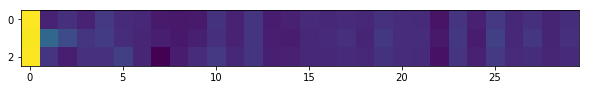

In [188]:
plt.figure(figsize=(10, 10)); plt.imshow(DATA[0])

Text(0.5, 0, 'z')

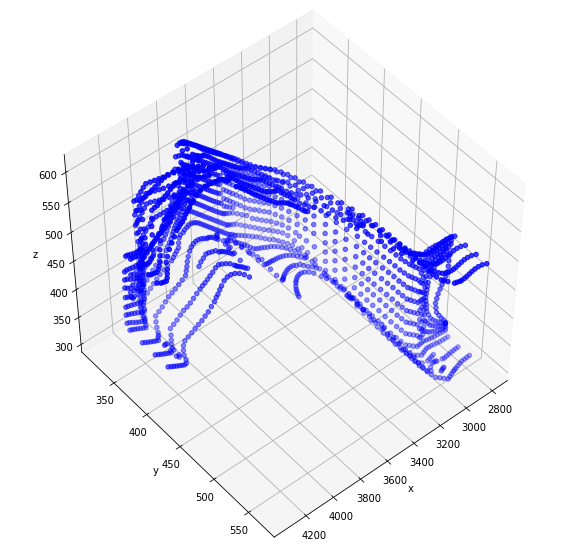

In [189]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

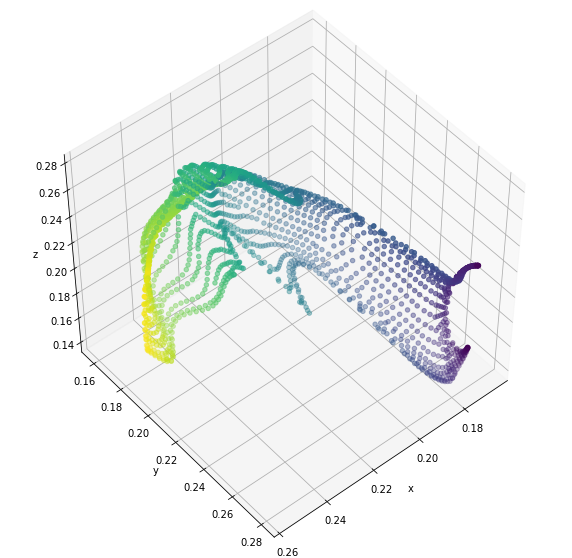

In [190]:
xyz = np.dot(DATA[0], np.linalg.pinv(ds))
print (xyz.shape)
cl = np.linalg.norm(np.abs(xyz - ds1), axis=0)
cl = (cl-np.amin(cl))/(np.amax(cl)-np.amin(cl))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=cl, marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

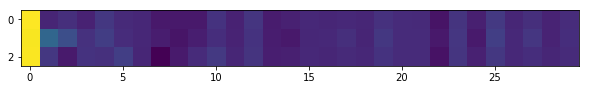

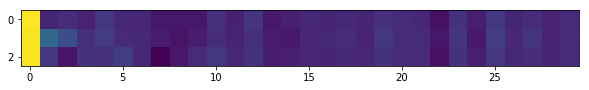

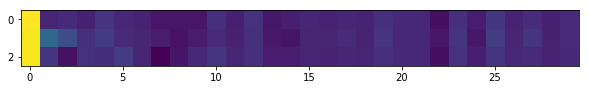

In [191]:
plt.figure(figsize=(10, 10)); plt.imshow(DATA[dim-1])
plt.figure(figsize=(10, 10)); plt.imshow(DATA[dim])
plt.figure(figsize=(10, 10)); plt.imshow(DATA[dim+1])

------------------------------part embedding------------------------------

In [216]:
dim2 = 100
vae = LSTM_Var_Autoencoder(intermediate_dim = 100, z_dim = 3, n_dim=d, stateful = True) #default stateful = False

vae.fit(DATA[0:dim2*st], learning_rate=0.0001, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=0.01, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.01088
Epoch   11   Loss 0.00257
Epoch   21   Loss 0.00085
Epoch   31   Loss 0.00016
Epoch   41   Loss 0.00002
Epoch   51   Loss 0.00001
Epoch   61   Loss 0.00001
Epoch   71   Loss 0.00001
Epoch   81   Loss 0.00001
Epoch   91   Loss 0.00001


Training time 1.75 minutes


In [217]:
x_reconstructed, recons_error = vae.reconstruct(DATA[dim2*st:], get_error = True) #returns squared error

x_reduced = vae.reduce(DATA) #latent space representation

Text(0.5, 0, 'latent 3')

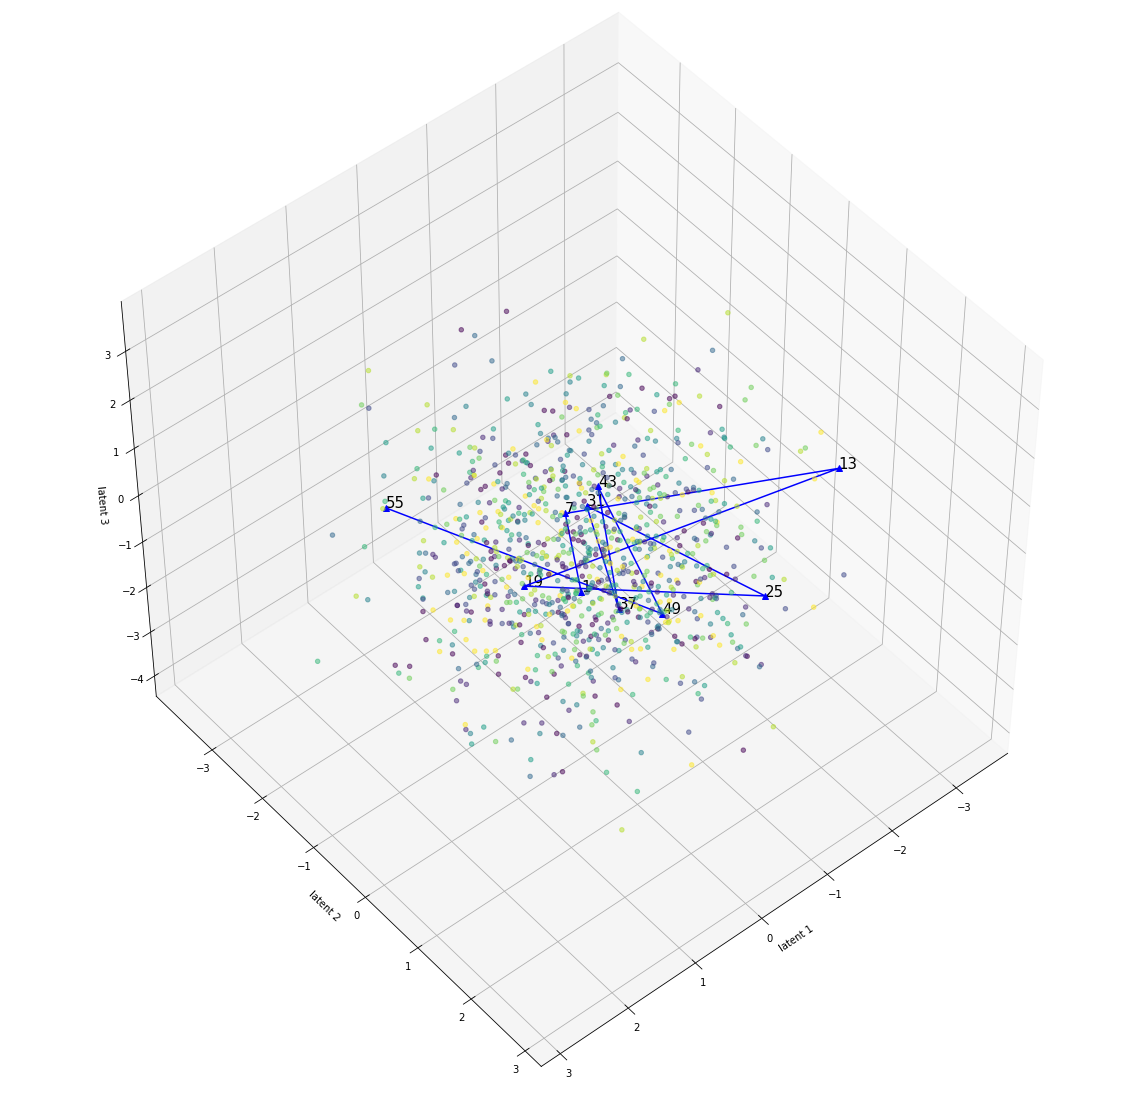

In [218]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']
label = []
for i in range(0, st):
    label.append(np.str(i*stride+1))
cl = np.zeros((dim2*st))    
for i in range(dim2):
    for j in range(st):
        cl[i*st + j] = j*(st/255.0)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced[0:dim2*st, 0], x_reduced[0:dim2*st, 1], x_reduced[0:dim2*st, 2], c=cl, marker=m[0], alpha=0.5)
ax.plot(x_reduced[dim2*st:(dim2+1)*st, 0], x_reduced[dim2*st:(dim2+1)*st, 1], x_reduced[dim2*st:(dim2+1)*st, 2], c=c[1], marker=m[1])
ii = 0
for i in range(dim2*st, (dim2+1)*st):
    ax.text(x_reduced[i, 0], x_reduced[i, 1], x_reduced[i, 2], label[ii], size=15, zorder=1, color='k') 
    ii += 1
ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

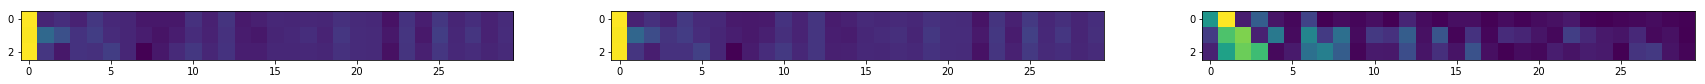

In [219]:
plt.figure(figsize=(30, 60)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed[0])
plt.subplot(1,3,2); plt.imshow(DATA[dim2*st])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed[0] - DATA[dim2*st]))

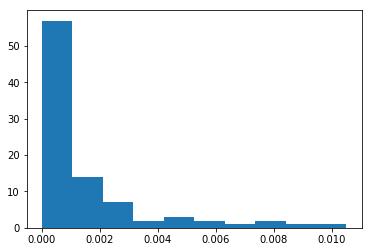

In [220]:
_,_,_ = plt.hist(np.abs(x_reconstructed[0] - DATA[dim2*st]).reshape((3*d)), bins=10)

(3, 1714)
(3, 1714)


Text(0.5, 0, 'z')

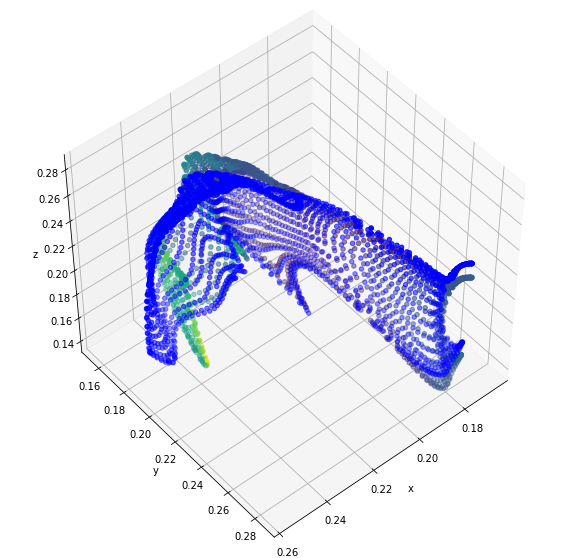

In [221]:
xyz = np.dot(DATA[dim2*st], np.linalg.pinv(ds))
xyz_reconstructed = np.dot(x_reconstructed[0], np.linalg.pinv(ds))
cl = np.linalg.norm(np.abs(xyz - xyz_reconstructed), axis=0)
cl = (cl-np.amin(cl))/(np.amax(cl)-np.amin(cl))
print (xyz_reconstructed.shape)
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=cl, marker=m[1])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [198]:
print (x_reduced.shape)
DATA2 = []
for i in range(dim):
    D = x_reduced[i*st:(i+1)*st, :].T
    D[0] = D[0]/np.linalg.norm(D[0])
    D[1] = D[1]/np.linalg.norm(D[1])
    D[2] = D[2]/np.linalg.norm(D[2])
    #for ii in range(len(D)):
    #    D[:, ii] = D[:, ii]/np.linalg.norm(D[:, ii])
    #D = D/np.linalg.norm(D)
    DATA2.append(D)
print (len(DATA2), DATA2[0].shape)  
dd = st

(2050, 3)
205 (3, 10)


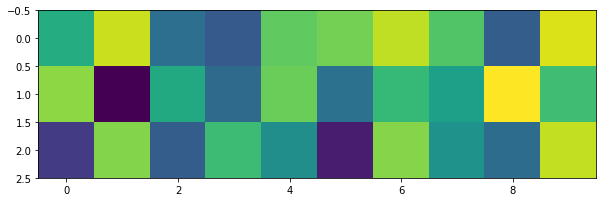

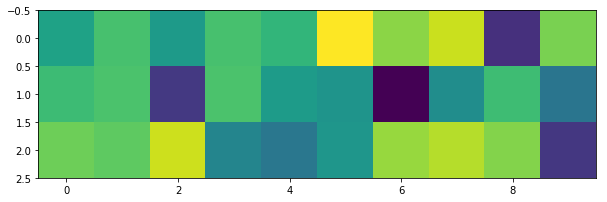

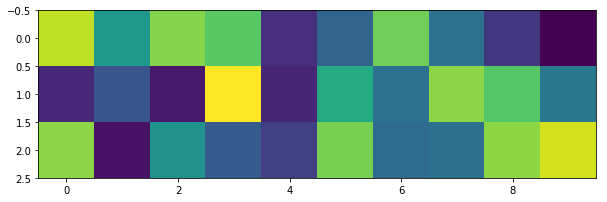

In [199]:
plt.figure(figsize=(10, 10)); plt.imshow(DATA2[dim2-1])
plt.figure(figsize=(10, 10)); plt.imshow(DATA2[dim2])
plt.figure(figsize=(10, 10)); plt.imshow(DATA2[dim2+1])

------------------------------sequence embedding------------------------------

In [200]:
vae2 = LSTM_Var_Autoencoder(intermediate_dim = 100, z_dim = 3, n_dim=dd, stateful = True) #default stateful = False

vae2.fit(DATA2[0:dim2], learning_rate=0.001, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.10226
Epoch   11   Loss 0.10012
Epoch   21   Loss 0.09996
Epoch   31   Loss 0.10002
Epoch   41   Loss 0.09989
Epoch   51   Loss 0.09967
Epoch   61   Loss 0.09989
Epoch   71   Loss 0.09977
Epoch   81   Loss 0.09965
Epoch   91   Loss 0.09985


Training time 0.17 minutes


In [201]:
x_reconstructed2, recons_error2 = vae2.reconstruct(DATA2[dim2:], get_error = True) #returns squared error

x_reduced2 = vae2.reduce(DATA2) #latent space representation

Text(0.5, 0, 'latent 3')

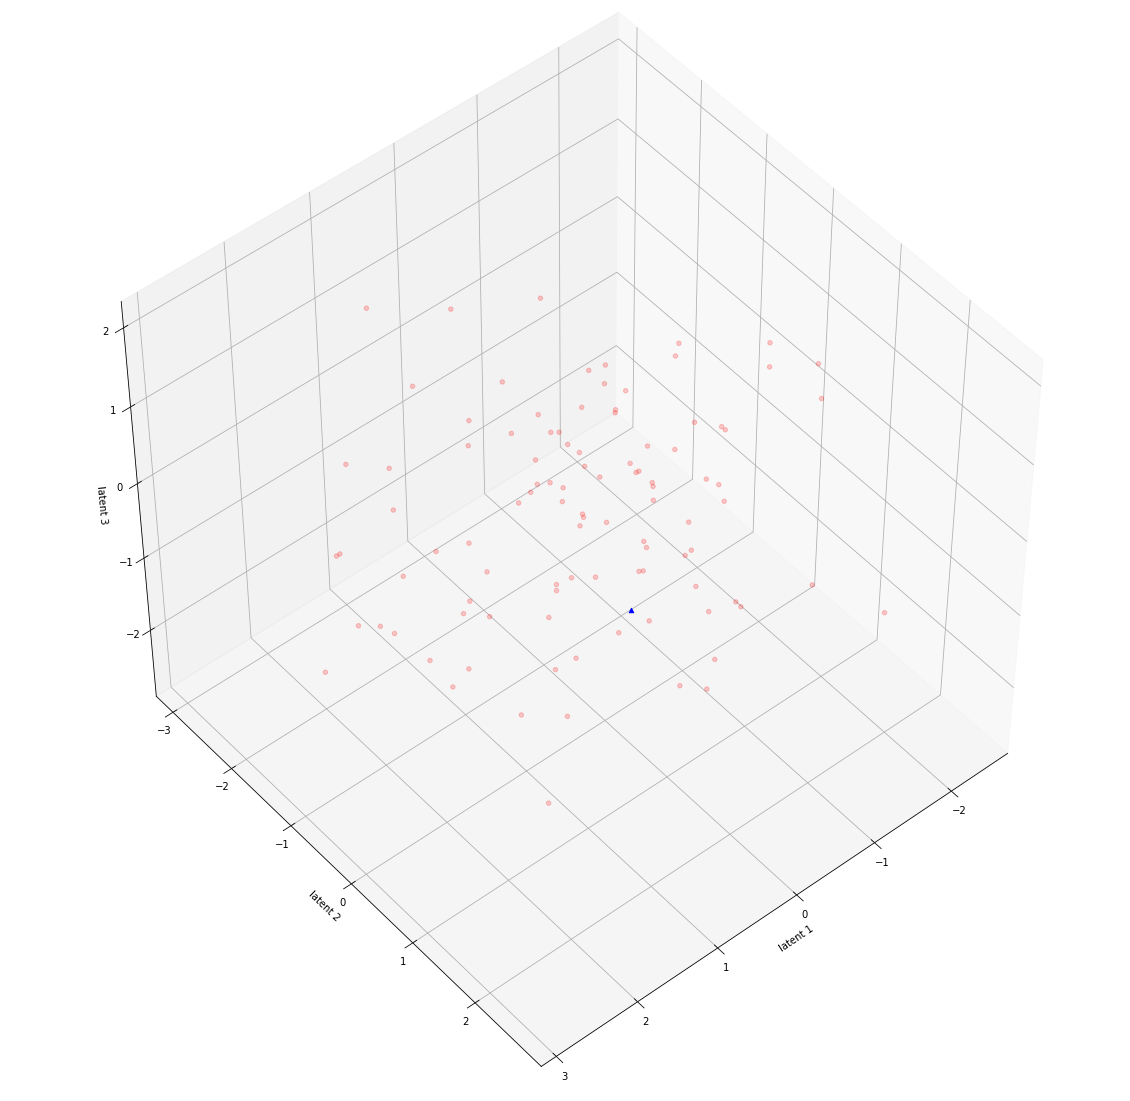

In [202]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced2[0:dim2, 0], x_reduced2[0:dim2, 1], x_reduced2[0:dim2, 2], c=c[0], marker=m[0], alpha=0.2)
ax.scatter(x_reduced2[dim2:dim2+1, 0], x_reduced2[dim2:dim2+1, 1], x_reduced2[dim2:dim2+1, 2], c=c[1], marker=m[1])

ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

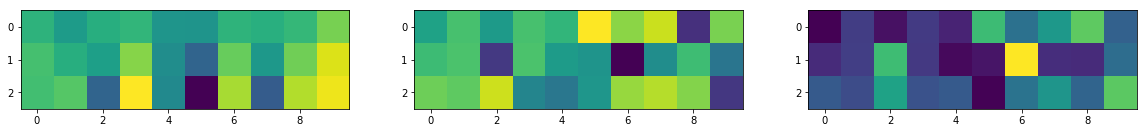

In [203]:
plt.figure(figsize=(20, 60)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed2[0])
plt.subplot(1,3,2); plt.imshow(DATA2[dim2])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed2[0] - DATA2[dim2]))

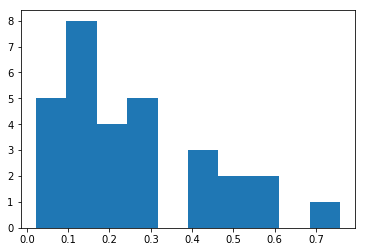

In [204]:
_,_,_ = plt.hist(np.abs(x_reconstructed2[0] - DATA2[dim2]).reshape((3*dd)), bins=10)

In [205]:
DATA3 = []
for i in range(dim):
    D = np.asarray(DATA[i*st:(i+1)*st]).reshape(st*3, d)
    DATA3.append(D)
print (len(DATA3), DATA3[0].shape)  
ddd = st*3
print (ddd, d)
dim3 = 100

205 (30, 30)
30 30


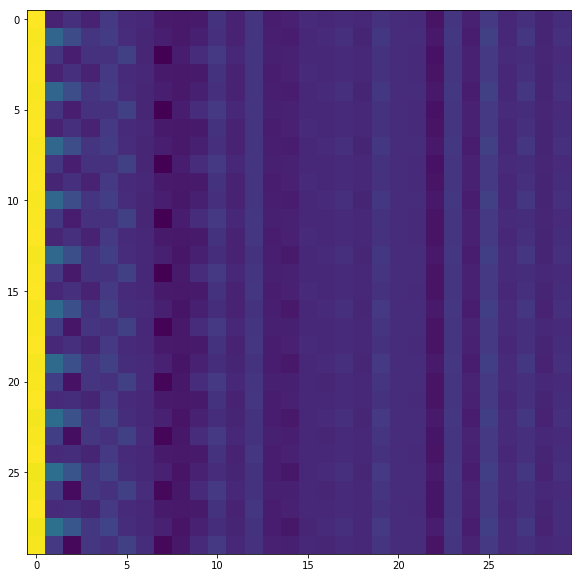

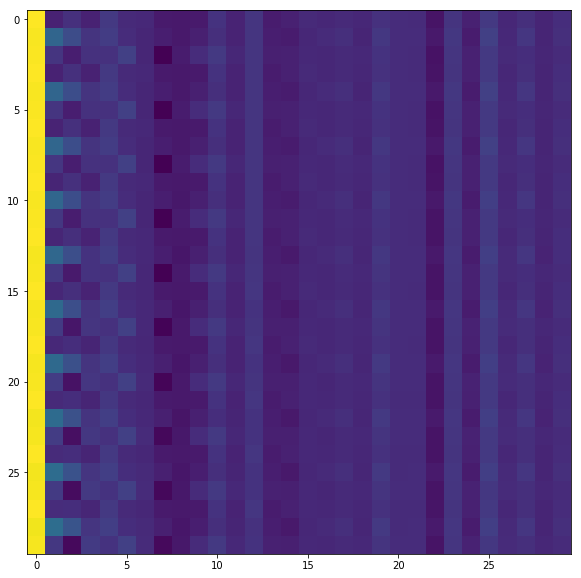

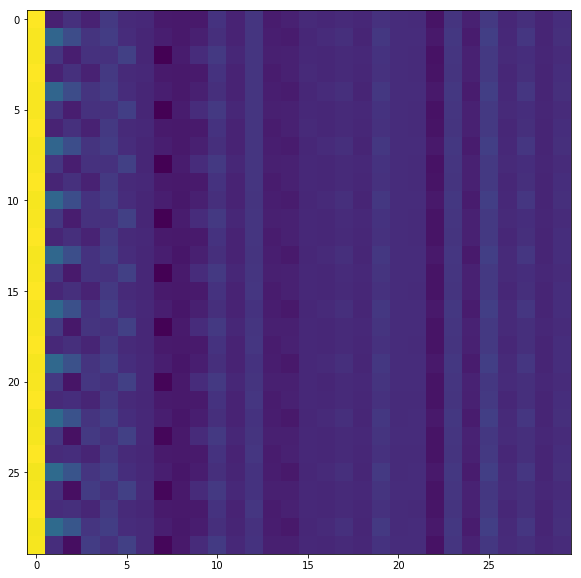

In [206]:
plt.figure(figsize=(10, 10)); plt.imshow(DATA3[dim3-1])
plt.figure(figsize=(10, 10)); plt.imshow(DATA3[dim3])
plt.figure(figsize=(10, 10)); plt.imshow(DATA3[dim3+1])

------------------------------sequence embedding------------------------------

In [208]:
vae3 = LSTM_Var_Autoencoder(intermediate_dim = 1000, z_dim = 3, n_dim=d, stateful = True) #default stateful = False

vae3.fit(DATA3[0:dim3], learning_rate=0.005, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.93661
Epoch   11   Loss 0.00039
Epoch   21   Loss 0.00031
Epoch   31   Loss 0.00028
Epoch   41   Loss 0.00025
Epoch   51   Loss 0.00004
Epoch   61   Loss 0.00001
Epoch   71   Loss 0.00000
Epoch   81   Loss 0.00000
Epoch   91   Loss 0.00000


Training time 7.93 minutes


In [209]:
x_reconstructed3, recons_error3 = vae3.reconstruct(DATA3[dim3:], get_error = True) #returns squared error

x_reduced3 = vae3.reduce(DATA3) #latent space representation

Text(0.5, 0, 'latent 3')

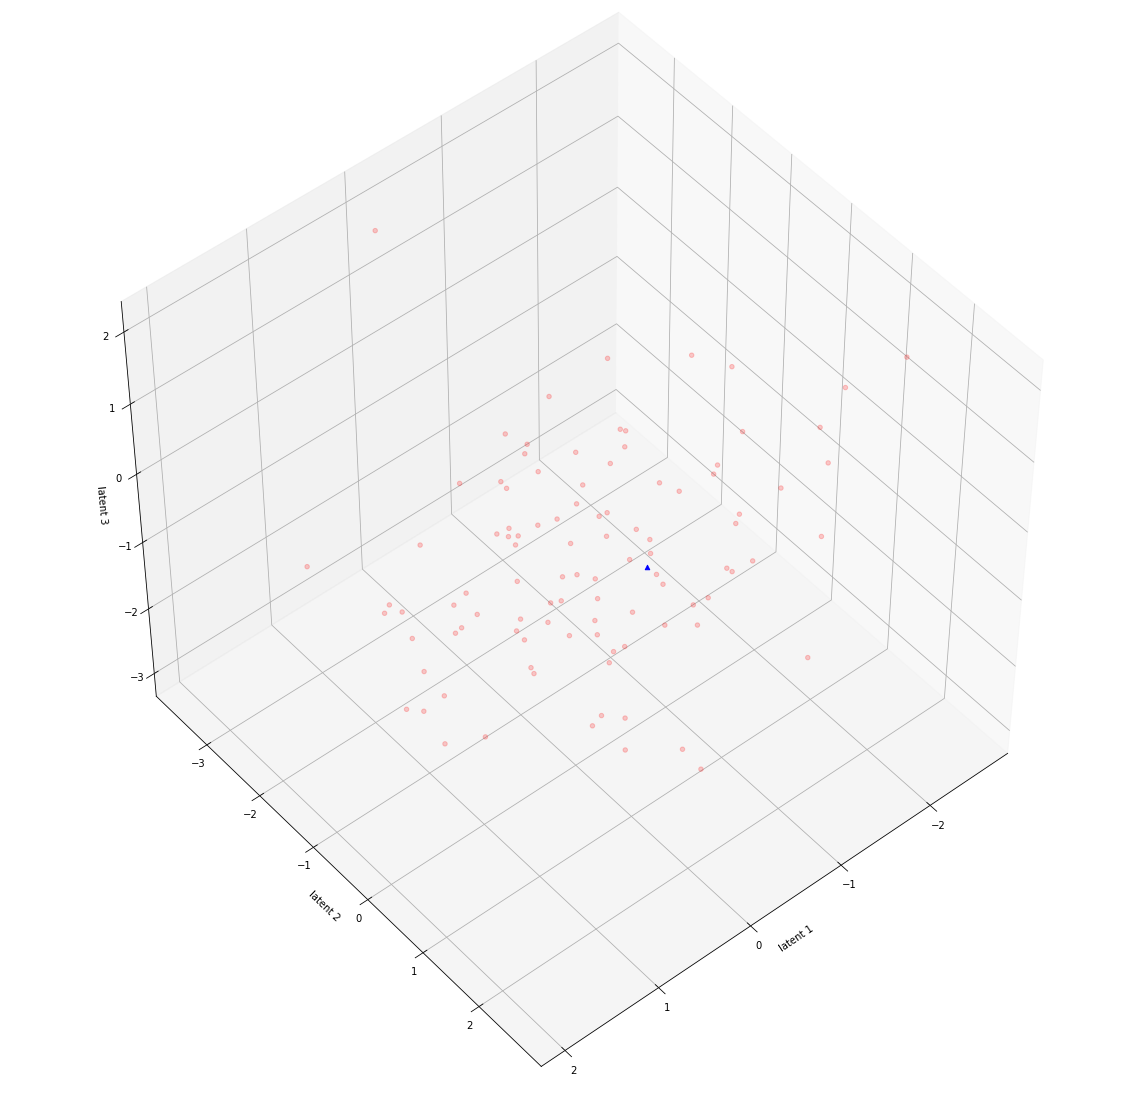

In [210]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced3[0:dim3, 0], x_reduced3[0:dim3, 1], x_reduced3[0:dim3, 2], c=c[0], marker=m[0], alpha=0.2)
ax.scatter(x_reduced3[dim3:dim3+1, 0], x_reduced3[dim3:dim3+1, 1], x_reduced3[dim3:dim3+1, 2], c=c[1], marker=m[1])

ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

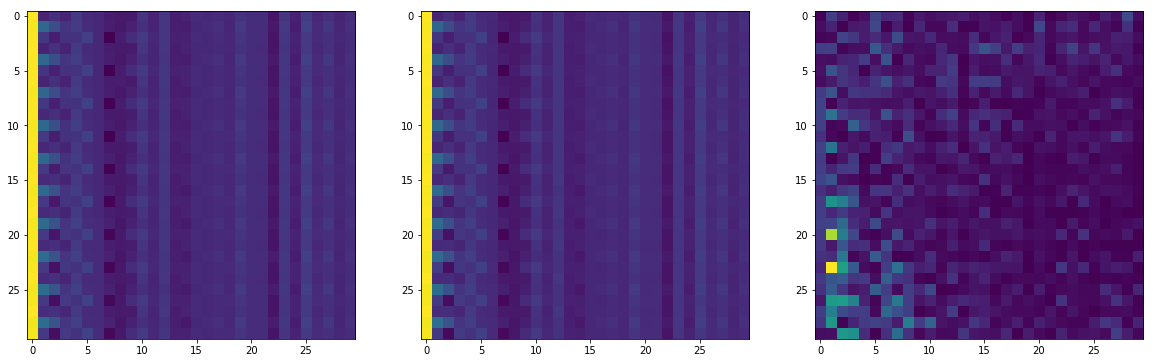

In [211]:
plt.figure(figsize=(20, 60)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed3[0])
plt.subplot(1,3,2); plt.imshow(DATA3[dim3])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed3[0] - DATA3[dim3]))

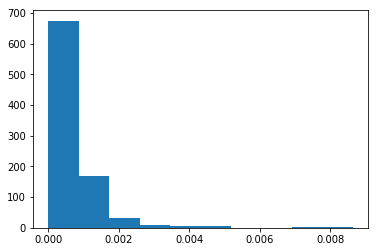

In [212]:
_,_,_ = plt.hist(np.abs(x_reconstructed3[0] - DATA3[dim3]).reshape((d*ddd)), bins=10)

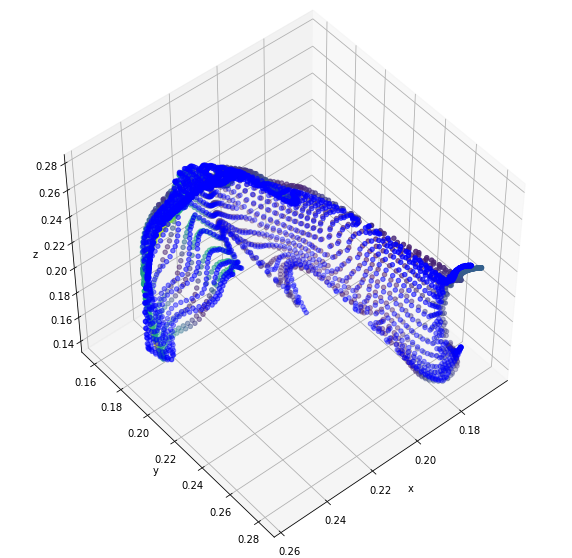

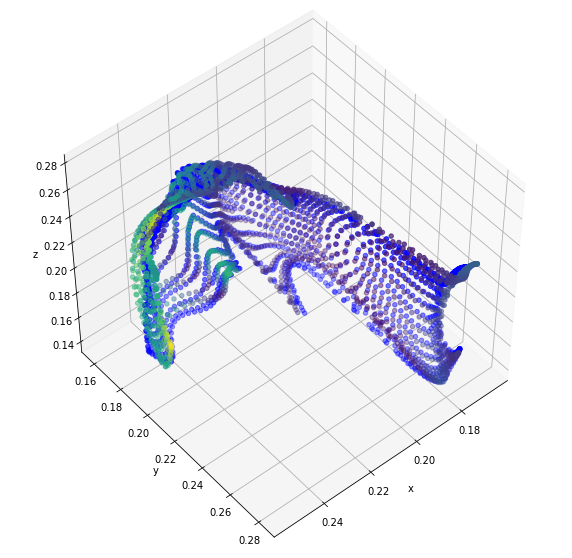

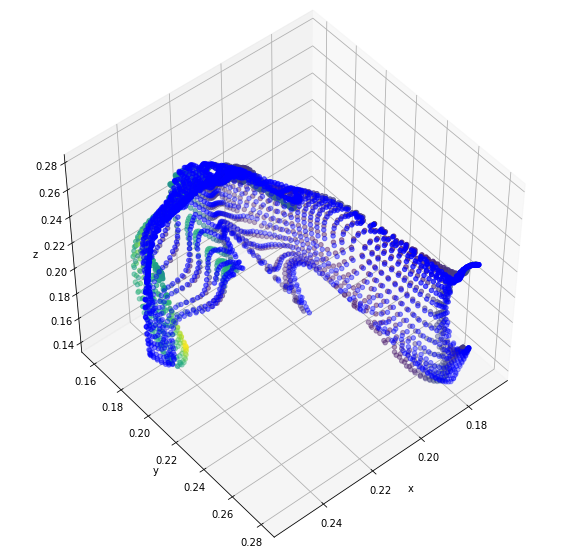

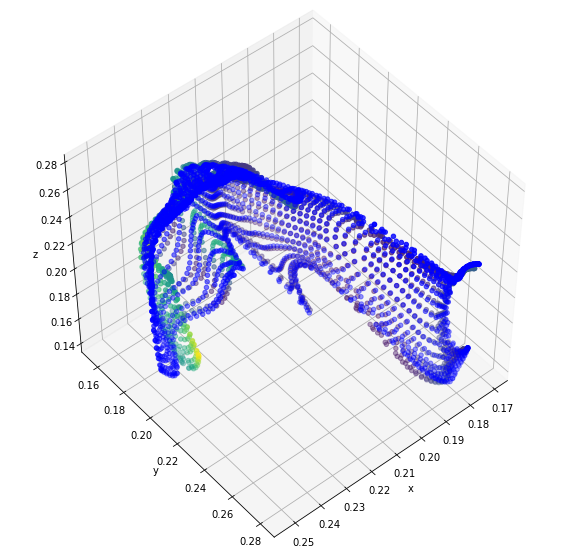

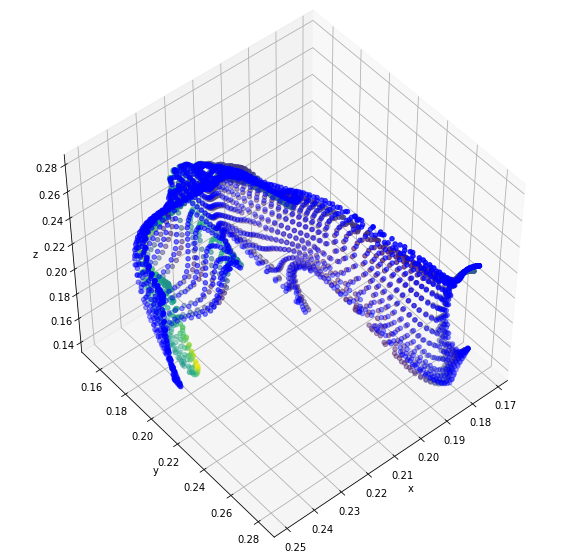

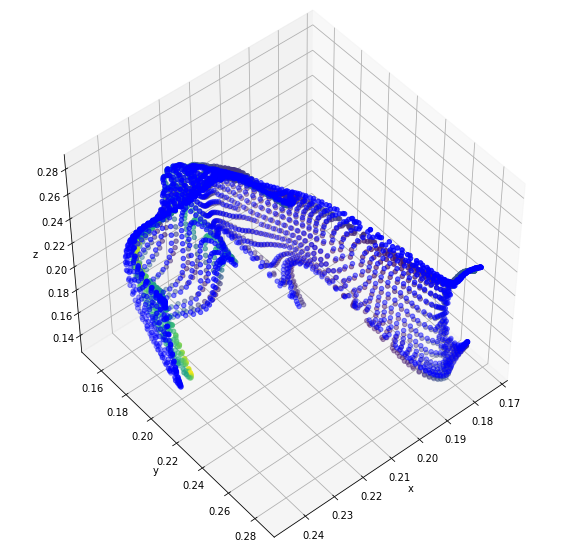

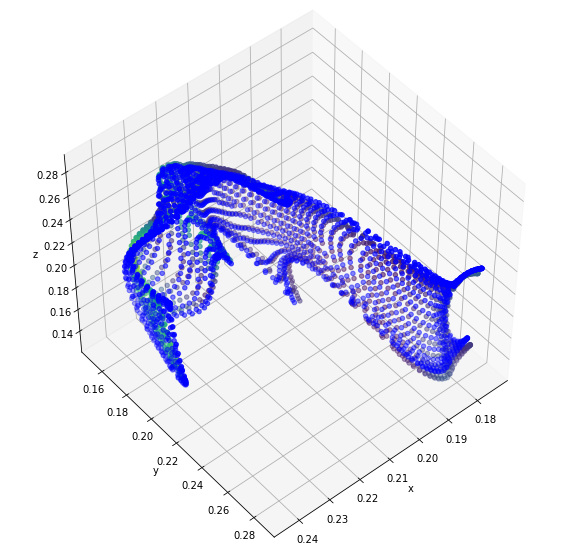

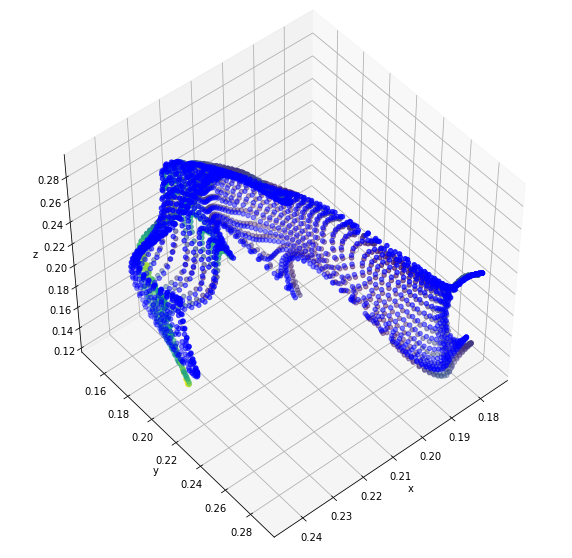

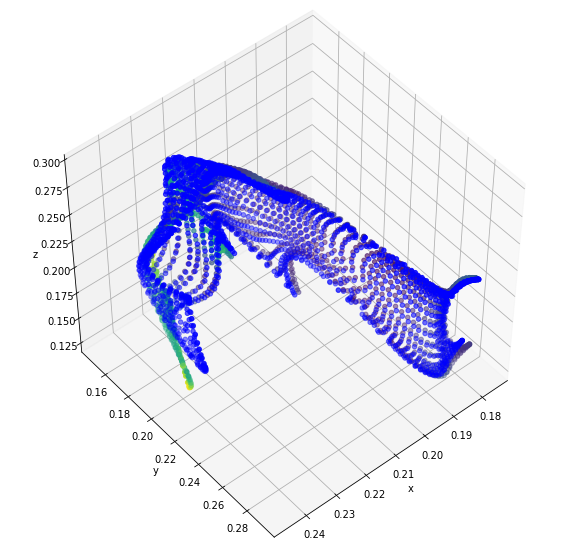

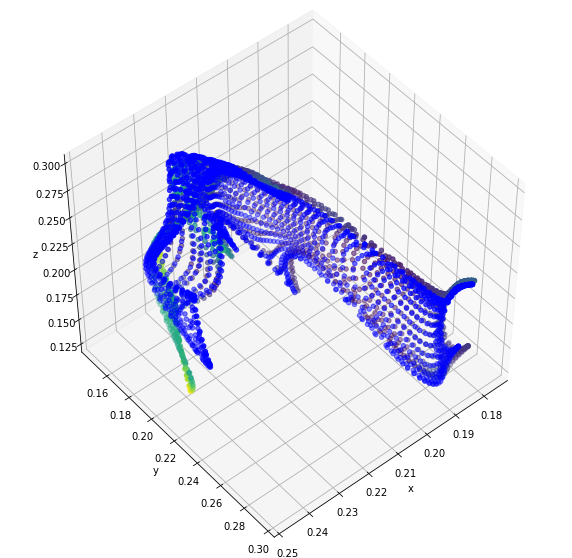

In [213]:
for i in range(st):
    xyz3 = np.dot(DATA[dim3*st+i], np.linalg.pinv(ds))
    xyz_reconstructed3 = np.dot(x_reconstructed3[0, i*3:(i+1)*3], np.linalg.pinv(ds))
    cl = np.linalg.norm(np.abs(xyz - xyz_reconstructed), axis=0)
    cl = (cl-np.amin(cl))/(np.amax(cl)-np.amin(cl))
    fig = plt.figure(figsize=(10, 10))
    c = ['b', 'r']
    m = ['o', 'o']
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xyz_reconstructed3[0], xyz_reconstructed3[1], xyz_reconstructed3[2], c=cl, marker=m[1])
    ax.scatter(xyz3[0], xyz3[1], xyz3[2], c=c[0], marker=m[0])
    ax.view_init(50, 50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z') 